In [1]:
from keras.src.callbacks import EarlyStopping

from database_io import *
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy import optimize as optim


print(np.__version__)


1.26.4


In [2]:
# path of databases (must exist)
db_path = "db/"

# filenames of databases (this must be sqlite3 databases)
train_fname = "surf17BigBoy_train.db"
validation_fname = "surf17_validation.db"
test_fname = "surf17_test.db"

dim_syndr = 8 # Ancilla Qubts
dim_fsyndr = 4 # distance 3 + 1 for final output parity
n_steps_net1 = 20 #
n_steps_net2 = 3 # distance

data = DatabaseIO(dim_syndr, dim_fsyndr, n_steps_net1, n_steps_net2)

In [3]:
try:
    data.close_databases()
except:
    pass
data.load_data(db_path + train_fname, db_path + validation_fname, db_path + test_fname)



batch_size = 64
n_batches_train = 1000
n_batches_validation = 100



class DecoderSequence(Sequence):
    def __init__(self, data, batch_size, n_batches, data_type):
        self.data = data
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.data_type = data_type
        self.on_epoch_end()

    def __len__(self):
        return self.n_batches

    def __getitem__(self, idx):
        # return the idx-th batch captured at epoch start
        return self.epoch_batches[idx]

    def on_epoch_end(self):
        """Called automatically by Keras at the end of each epoch."""
        gen = self.data.gen_batches(
            self.batch_size,
            self.n_batches,
            data_type=self.data_type
        )

        self.epoch_batches = []
        for _ in range(self.n_batches):
            batch_x1, batch_x2, batch_fx, batch_l1, batch_l2, batch_y = next(gen)

            # Wrap into Keras multi-input format
            inputs = (batch_x1, batch_x2, batch_fx) #, batch_l1, batch_l2)
            outputs = batch_y
            self.epoch_batches.append((inputs, outputs))

train_seq = DecoderSequence(
    data,
    batch_size=batch_size,
    n_batches=n_batches_train,
    data_type='training'
)

val_seq = DecoderSequence(
    data,
    batch_size=batch_size,
    n_batches=n_batches_validation,
    data_type='validation'
)


loaded databases and checked exclusiveness training, validation, and test keys
N_training=1000000, N_validaiton=10000, N_test=50000.


In [5]:
# DEFINING THE MODEL
x1 = Input(shape=(None, dim_syndr), name="x1_full")
x2 = Input(shape=(n_steps_net2, dim_syndr), name="x2_recent")
fx = Input(shape=(dim_fsyndr,), name="final_increment")

dropout_rate = 0.2
layer_width = 64

# Network 1 (full syndrome history)
h1 = layers.LSTM(layer_width, activation="tanh", return_sequences=True, kernel_regularizer=keras.regularizers.l2(1e-5))(x1)
h1 = layers.Dropout(dropout_rate)(h1)
h1 = layers.LSTM(layer_width, activation="tanh", kernel_regularizer=keras.regularizers.l2(1e-5))(h1)
h1 = layers.Dropout(dropout_rate)(h1)
p1 = layers.Dense(layer_width, activation="relu", name="p1", kernel_regularizer=keras.regularizers.l2(1e-5))(h1)
p1 = layers.Dropout(dropout_rate)(p1)
p1 = layers.Dense(1, activation="sigmoid", kernel_regularizer=keras.regularizers.l2(1e-5), name="p1_prob")(p1)


# Network 2 (recent syndrome + final increment)
h2 = layers.LSTM(layer_width, activation="tanh", kernel_regularizer=keras.regularizers.l2(1e-5), return_sequences=True)(x2)
h2 = layers.Dropout(dropout_rate)(h2)
h2 = layers.LSTM(layer_width, activation="tanh", kernel_regularizer=keras.regularizers.l2(1e-5))(h2)
h2 = layers.Dropout(dropout_rate)(h2)

p2 = layers.Concatenate()([h2, fx])
p2 = layers.Dense(layer_width, activation="relu", name="p2", kernel_regularizer=keras.regularizers.l2(1e-5))(p2)
p2 = layers.Dropout(dropout_rate)(p2)
p2 = layers.Dense(1, activation="sigmoid", name="p2_prob", kernel_regularizer=keras.regularizers.l2(1e-5))(p2)


# Final combination p = probabilistic sum
p_final = layers.Lambda(lambda x: x[0]*(1-x[1]) + x[1]*(1-x[0]))([p1, p2]) # XOR Gate

model = Model(inputs=[x1, x2, fx], outputs=p_final)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ x2_recent           │ (None, 3, 8)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x1_full             │ (None, None, 8)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 3, 64)     │     18,688 │ x2_recent[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, None, 64)  │     18,688 │ x1_full[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 3, 64)     │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 64)  │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 64)        │     33,024 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     33,024 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_increment     │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 68)        │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ final_increment[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p1 (Dense)          │ (None, 64)        │      4,160 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p2 (Dense)          │ (None, 64)        │      4,416 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ p1[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ p2[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p1_prob (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p2_prob (Dense)     │ (None, 1)         │         65 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ p1_prob[0][0],    │
│                     │                   │            │ p2_prob[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 112,130 (438.01 KB)

 Trainable params: 112,130 (438.01 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# COMPILING AND TRAINING THE MODEL
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=["accuracy"]
)

num_epochs = 1000

checkpoint = ModelCheckpoint(
    'best_model.keras',        # file path to save the model
    monitor='val_accuracy',    # metric to monitor
    verbose=1,                 # prints message when saving
    save_best_only=True,       # only save if improved
    mode='max'                 # 'min' for loss, 'max' for accuracy
)

early_stop = EarlyStopping(
    monitor='val_accuracy',    # use validation accuracy to monitor
    patience=50,               # stop after n epochs with no improvement
    min_delta=1e-4,            # threshold for minimum change over epochs -> "no imporovement"
    restore_best_weights=True, # keeps weights from the best epoch
    verbose=1
)


results = model.fit(
    train_seq,
    steps_per_epoch=n_batches_train,
    epochs=num_epochs,
    verbose=1,
    validation_data=val_seq,
    validation_steps=n_batches_validation,
    callbacks=[checkpoint, early_stop]
)

/opt/anaconda3/envs/phys139-project/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5723 - loss: 0.6823
Epoch 1: val_accuracy improved from None to 0.50359, saving model to best_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5797 - loss: 0.6778 - val_accuracy: 0.5036 - val_loss: 0.7362
Epoch 2/1000
 995/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6825 - loss: 0.4920
Epoch 2: val_accuracy did not improve from 0.50359
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7278 - loss: 0.4389 - val_accuracy: 0.5036 - val_loss: 0.7417
Epoch 3/1000
 996/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7966 - loss: 0.3695
Epoch 3: val_accuracy did not improve from 0.50359
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8003 - loss: 0.3655 - val_accuracy: 0.4997 - val_loss: 0.7474
Epoch 4/1000
 997/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8225 - loss: 0.3334
Epoch 4: val_accuracy improved from 0.50359 to 0.50453, saving model to best_model.ke

Text(0.5, 1.0, 'No Mask Model')

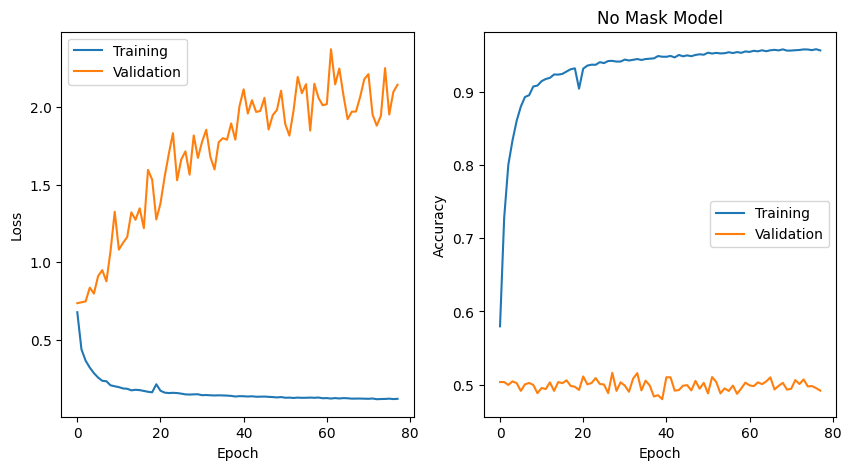

In [7]:
from plotting import plot_model_history, make_roc
plot_model_history(results)
plt.title("No Mask Model")


In [8]:
# stat calculation taken from original code

def decay(x, p_logical, x0):
  """ This functions is used to make a exponential fit to the fidelity
      curves """
  return (1 + (1 - 2 * p_logical)**(x - x0)) / 2.

def calc_stats(data, n_sampling=5000, x0_max=10, verbose=False):
    """ calculates the logical error rate and error bars """

    # since it is possible that the batch does not contain fidelities
    # for all steps, hence we need a list with all steps for which
    # predictions excist (we call it 'steps')
    steps, data_nonzero = [], []
    fids, rs_means_l, plogs_bs = [], [], []

    # in the following we assume that the first step is s = 1
    for s in range(1, len(data) + 1):
        dat = data[s - 1]
        if len(dat) != 0:
            # non-trivial data points
            steps.append(s)
            data_nonzero.append(dat)
            # fidelities
            fids.append(np.mean(dat))

    # fit decay curve to the non-tivial data
    popt, pcov = optim.curve_fit(
        decay, steps, fids, bounds=((0.0001, 0.0001), (.1, x0_max)))
    plog, x0 = popt[0], popt[1]
    if x0 > 0.99 * x0_max:
        print("WARNING, x0 is larger than", x0_max,
            "the fitting algorithm fails")
    if plog > .09:
        print("WARNING, plog is larger than 9%, the fitting algorithm fails")



    res_dict = {'steps': steps, 'fids': fids, 'plog': plog, 'x0': x0, 'plog_error': np.sqrt(pcov[0,0])}
    if verbose:
        print("logical error rate:", round(plog * 100, 5), "%")
        print("x0 offset", round(x0, 3))

    return res_dict


In [9]:


num_samples = int(10000)


batch = None
for gen in data.gen_batches(num_samples, 1, data_type='test'):
    batch = gen
x1, x2, fx, l1, _, y_actual = batch
y_prob = model.predict((x1,x2,fx))


7188/7188 ━━━━━━━━━━━━━━━━━━━━ 148s 21ms/step


# Figure 3

logical error rate: 3.70453 %
x0 offset 1.367


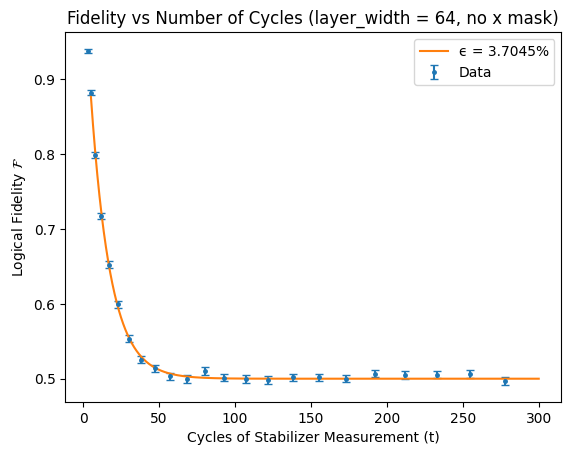

Overall Accuracy: 0.5746826086956522


In [13]:
y_preds_bool = np.empty_like(y_actual)
l_arr = np.array(range(501))
errors = np.zeros_like(l_arr)
samples = np.zeros_like(l_arr)
for idx in range(y_actual.size):
    samples[l1[idx]] += 1
    y_pred = y_prob[idx] > 0.5
    y_preds_bool[idx] = y_pred
    if (y_pred != y_actual[idx]) :
        errors[l1[idx]] += 1

comp_list = np.equal(y_preds_bool, y_actual).astype('float')
comparison = []
for n in range(max(l1)):
    comparison.append([])
for n in range(len(comp_list)):
    idx = l1[n] - 1
    comparison[idx].append(comp_list[n])
stats_dict = calc_stats(comparison, n_sampling=5000, x0_max=10, verbose=True)
fidelity = np.divide(samples - errors, samples, out=np.zeros_like(errors, dtype=float), where=(samples != 0)).astype(float)

x, y, yerr = [], [], []
for idx in range(len(fidelity)):
    if (fidelity[idx] != 0):
        x.append(l_arr[idx])
        y.append(fidelity[idx])

        # binomial error calculation (bootstraps 3sigma)
        se = np.sqrt(fidelity[idx] * (1 - fidelity[idx]) / samples[idx])
        yerr.append(se)


plog = stats_dict['plog']
x0 = stats_dict['x0']

t = np.linspace(5, 300, 10000)
F = (1 + (1 - 2 * plog)**(t - x0)) / 2

plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=3, label='Data', markersize=2.5)
plt.title(f"Fidelity vs Number of Cycles (layer_width = {layer_width}, no x mask)")
plt.plot(t, F, linestyle = "-", label = f"ϵ = {round(plog*100, 4)}%")

plt.legend()
plt.ylabel(r"Logical Fidelity $\mathcal{F}$")
plt.xlabel("Cycles of Stabilizer Measurement (t)")
plt.grid(0)
plt.savefig(f"Figure3_N={num_samples}no_mask.png", dpi=300)
plt.show()

print(f"Overall Accuracy: {1 - np.sum(errors) / np.sum(samples)}")

'# Figure 4 Data

In [15]:
Figure4_lst = []
Figure4_error_lst =[]
fy_lst = [0, 0.5, 1, 1.5, 2]

for fy in fy_lst:
    test_fname = f"surf17fy{fy}_test.db"



    batch = None
    for gen in data.gen_batches(num_samples, 1, data_type='test'):
        batch = gen
    x1, x2, fx, l1, _, y_actual = batch
    y_prob = model.predict((x1,x2,fx))

    print(f"fy = {fy}")

    y_preds_bool = np.empty_like(y_actual)
    l_arr = np.array(range(501))
    errors = np.zeros_like(l_arr)
    samples = np.zeros_like(l_arr)
    for idx in range(y_actual.size):
        samples[l1[idx]] += 1
        y_pred = y_prob[idx] > 0.5
        y_preds_bool[idx] = y_pred
        if (y_pred != y_actual[idx]) :
            errors[l1[idx]] += 1

    comp_list = np.equal(y_preds_bool, y_actual).astype('float')
    comparison = []
    for n in range(max(l1)):
        comparison.append([])
    for n in range(len(comp_list)):
        idx = l1[n] - 1
        comparison[idx].append(comp_list[n])
    stats_dict = calc_stats(comparison, n_sampling=5000, x0_max=10, verbose=True)

    Figure4_lst.append(stats_dict['plog'])
    Figure4_error_lst.append(stats_dict['plog_error'])

print(Figure4_lst)






7188/7188 ━━━━━━━━━━━━━━━━━━━━ 147s 20ms/step
fy = 0
logical error rate: 3.68836 %
x0 offset 1.376
7188/7188 ━━━━━━━━━━━━━━━━━━━━ 147s 21ms/step
fy = 0.5
logical error rate: 3.72391 %
x0 offset 1.544
7188/7188 ━━━━━━━━━━━━━━━━━━━━ 147s 20ms/step
fy = 1
logical error rate: 3.85226 %
x0 offset 1.689
7188/7188 ━━━━━━━━━━━━━━━━━━━━ 148s 21ms/step
fy = 1.5
logical error rate: 3.69267 %
x0 offset 1.481
7188/7188 ━━━━━━━━━━━━━━━━━━━━ 149s 21ms/step
fy = 2
logical error rate: 3.80265 %
x0 offset 1.506
[0.036883566276147556, 0.03723914012722606, 0.03852264777496776, 0.036926675390965176, 0.03802649368741634]


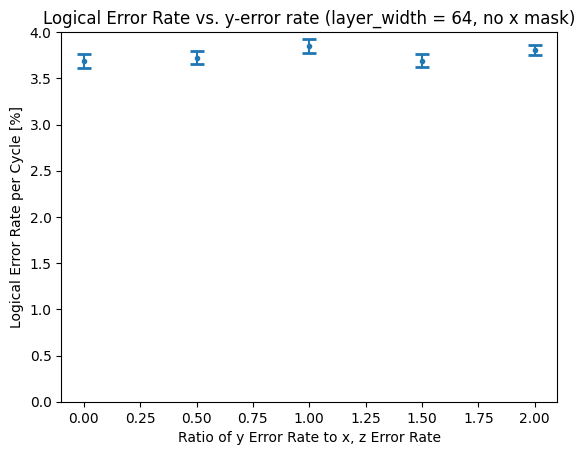

In [17]:
Figure4_lst_p = np.array(Figure4_lst)*100
Figure4_error_lst_p = np.array(Figure4_error_lst)*100

plt.errorbar(fy_lst, Figure4_lst_p, yerr=Figure4_error_lst_p, fmt='.', capsize=5, capthick=2)
plt.title(f"Logical Error Rate vs. y-error rate (layer_width = {layer_width}, no x mask)")
plt.xlabel("Ratio of y Error Rate to x, z Error Rate")
plt.ylabel(f"Logical Error Rate per Cycle [%]")
plt.ylim(0, 4)
plt.savefig(f"Figure4_N={num_samples}_no_mask.png", dpi=300)
plt.show()